### Исследовали 2 случая:  
$1) y'(A) = y'(-A) = z'(A) = z'(-A) = 0$ \
$2) y(A) = y(-A) = z(A) = z(-A) = 0 $

## КОД

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv, svd, norm
import random

In [2]:
colors = ['(255, 140, 0)', '(255, 69, 0)', '(154, 205, 50)', '(128, 128, 0)', '(85, 107, 47)',
              '(0, 128, 128)', '(70, 130, 180)', '(139, 69, 19)', '(105, 105, 105)']
random.shuffle(colors)
colors = [tuple(map(lambda x: int(x) / 255, color[1:-1].split(', '))) for color in colors]

In [3]:
def lambda_iterate(linsp, D, K, A, init_approx, system, bc, draw_nth, filename):
    global k11, k12, k13, k21, k22, k23
    k11, k12, k13, k21, k22, k23 = K
    global la
    params, bc_params = [], []
    lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
    lambdas_for_plot, dets = [], []
    lam_zeros = []
    lam_change_sign = []
    abcFile = open(filename, 'a')
    y_approx = init_approx
    cnt = 0
    time_steps = np.linspace(-A, A, 100)
    for la in lambdas:
        cnt += 1
        result = shooting(np.linspace(-A, A, 100), y_approx, system, params, bc, bc_params, filename)
        if result[0] > 1:
            print("MISTAKE AT la = ", la, "det = ", det, file=abcFile)
            continue
        print("y_approx = ", y_approx, " la = ", la, file = abcFile)
        if (len(dets) > 0 and result[3] * dets[-1] < 0):
            print("special lambda at", la)
            lam_zeros.append(la)
            return dets, lambdas_for_plot, lam_zeros, lam_change_sign
    # сохранить точку смены знака
        if len(dets) > 0 and result[3] * dets[-1] < 0:
            print('Det Change, lambda = {lamb}'.format(lamb = round(la, 2)))
            print("y_approx = ", y_approx, " la = ", la)
            lam_change_sign.append(la)
        y_approx = result[1]
        # la k1 k2
        lambdas_for_plot.append(la)
        dets.append(result[3])
    return dets, lambdas_for_plot, lam_zeros, lam_change_sign

def runge_kutta(f, y_value, steps):
    y = np.hstack((steps[0], y_value.copy()))
    for i in range(1, len(steps)):
        h = steps[i] - steps[i - 1]
        t1 = steps[i]
        k1 = count(f, y, 0, np.array([0] * (len(y) - 1)))
        k2 = count(f, y, h / 2, k1 * h / 2)
        k3 = count(f, y, h / 2, k2 * h / 2)
        k4 = count(f, y, h, k3 * h)
        y[1:] += h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y[0] = t1
    return y[1:]

def shooting(time_steps, y_approx, f, params, bc, bc_params, sourceFilename, solver=runge_kutta):
    # time_steps = np.linspace(-A, A, 100)
    global la
    boarder_values = bc
    y_value = y_approx
    eps = 1e-4
    step = 0
    determ = 0.0
    D = np.zeros((len(f), len(f)))
    left_steps, right_steps = time_steps[len(time_steps)//2::-1], time_steps[len(time_steps) // 2:]
#     print("len left steps, right steps = ", len(left_steps), len(right_steps))
    zeroDetFile = open('zeroDet.txt', 'a')
    while True:
        step += 1
        begin, end = np.array(runge_kutta(f, y_value, left_steps)), np.array(runge_kutta(f, y_value, right_steps))
#         print()
        redisuals = boarder_values(np.concatenate((begin, end)))
        if (np.abs(redisuals) < 1e-6).all():
            u, s, h = np.linalg.svd(D, full_matrices=False)
            return 0, y_value, redisuals, determ, s
        D = np.eye(len(f))
        for i in range(len(f)):
            y = y_value.copy()
            y[i] += eps
            dres = np.hstack((y, runge_kutta(f, y, time_steps)))
            begin, end = np.array(runge_kutta(f, y, left_steps )), np.array(runge_kutta(f, y, right_steps ))
            dres = np.hstack((begin, end))
            dr = boarder_values(dres)
            D[:, i] = (dr - redisuals) / eps
        determ = np.linalg.det(D)
        if abs(determ) < 1e-6:
#             u, s, h = np.linalg.svd(D, full_matrices=False)
            return 1, y_value, redisuals, determ, []
        if np.isnan(D).any():
            return 2, y_value, redisuals, determ, []
        if step > 10:
            return 3, y_value, redisuals, determ, []
        y_value = y_value - np.linalg.pinv(D) @ redisuals
    zeroDetFile.close()

def grkutta_(f, y_value, steps):   # different return
    y = np.hstack((steps[0], y_value.copy()))
    yval, zval = [y[1]], [y[2]]
    for i in range(1, len(steps)):
        h = steps[i] - steps[i - 1]
        t1 = steps[i]
        k1 = count(f, y, 0, np.array([0] * (len(y) - 1)))
        k2 = count(f, y, h / 2, k1 * h / 2)
        k3 = count(f, y, h / 2, k2 * h / 2)
        k4 = count(f, y, h, k3 * h)
        y[1:] += h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y[0] = t1
        yval.append(y[1])
        zval.append(y[2])
    return list(steps), yval, zval


def count(f, args, h, k):
    ''' calculates f(args[0] + h, args[1:] + k) '''
    res = []
    args0 = args.copy()
    args0[0] += h
    args0[1:] += k
    for i in range(len(f)):
        res.append(f[i](args0))
    return np.array(res)
def F1(args):
    x, y, z, dy, dz = args[:5]
    return dy
def F2(args):
    global la, k11, k12, k13
    x, y, z, dy, dz = args[:5]
    return (y + k11 * y**2 + 2 * k12 * z * y + k13 * z**2 + la) / D    # d^2y / dx^2
def G1(args):
    x, y, z, dy, dz = args[:5]
    return dz
def G2(args):
    global la, k21, k22, k23
    x, y, z, dy, dz = args[:5]
    return (z + k21 * y**2 + 2 * k22 * z * y + k23 * z**2 + la) / D     # d^2z / dx^2

system = [F1, G1, F2, G2]

# def boarder_values_(l):
#     return np.array([l[0], l[1], l[4], l[5]])
# #  0      1      2      3     4    5    6     7   
# # y(-A) z(-A) y'(-A) z'(-A) y(A) z(A) y'(A) z'(A)

# bc = boarder_values_
params = []


def boarder_values(l):
    return np.array([l[2], l[3], l[6], l[7]])
#  0      1      2      3     4    5    6     7   
# y(-A) z(-A) y'(-A) z'(-A) y(A) z(A) y'(A) z'(A)

bc = boarder_values

# y'(-A) = y'(A) = z'(-A) = z'(A) = 0

## График det lambda

D = 10, A = 2.0, K1 = 1.57, K2 = 10, linspace(0, 100, 1000)
Det Change, lambda = 3.4
y_approx =  [-2.81031432e+00  5.99377879e-02 -1.02826227e-07 -7.53026378e-07]  la =  3.4034034034034035
Det Change, lambda = 5.91
y_approx =  [-4.91965201e+00  5.96693622e-02  1.92480467e-09  2.89947084e-08]  la =  5.9059059059059065
Det Change, lambda = 9.21
y_approx =  [-7.70420780e+00  5.95402880e-02 -3.39032545e-09 -2.28032640e-08]  la =  9.20920920920921
Det Change, lambda = 13.31
y_approx =  [-1.11638958e+01  5.94700922e-02 -3.93275515e-08 -2.49693845e-07]  la =  13.313313313313314
Det Change, lambda = 18.02
y_approx =  [-1.51299212e+01  5.94282369e-02 -1.98922171e-09 -1.30316749e-08]  la =  18.01801801801802
Det Change, lambda = 23.52
y_approx =  [-1.97710349e+01  5.94010128e-02 -8.25309381e-09 -5.25299159e-08]  la =  23.523523523523526
Det Change, lambda = 29.73
y_approx =  [-2.50028482e+01  5.93823310e-02 -6.41453135e-10 -4.16828726e-09]  la =  29.72972972972973
Det Change, lambda = 36.74
y_ap

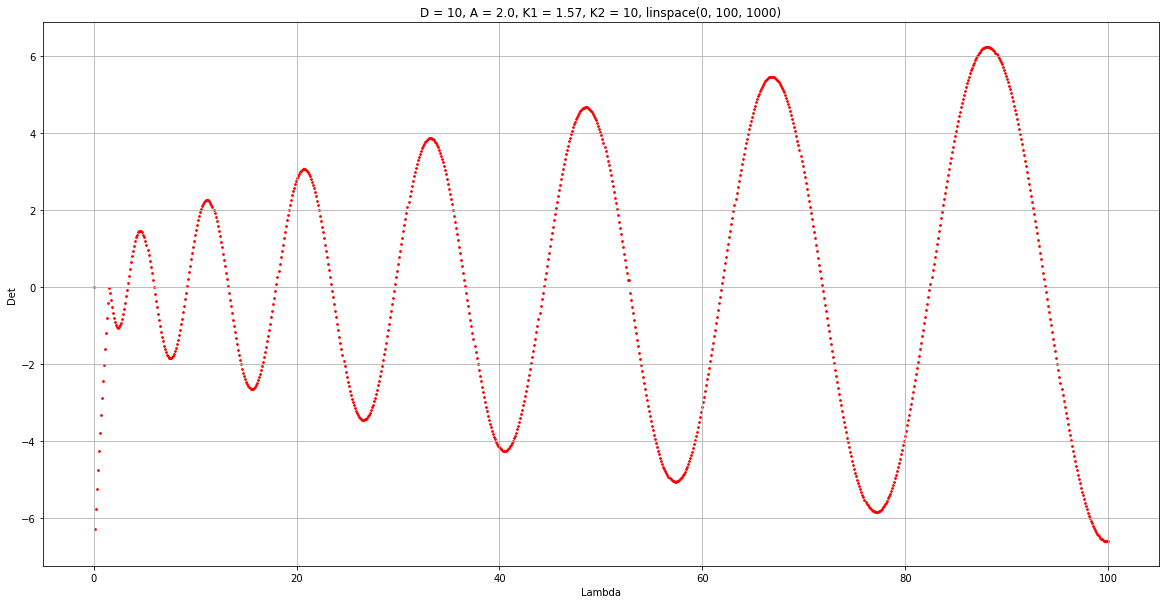

In [62]:
for ij in [1.57]:
    D, A, K1, K2 = 10, 2.0, ij, 10
    k11, k12, k13, k21, k22, k23 = 0, ij, 10, 0, 10, ij   #  0, K1, K2, 0, K2, K1
    init_approx =  [0, 0, 0, 0]
    linsp = [0, 100, 1000]
    lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
    print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij, K2 = 10, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
    K = [k11, k12, k13, k21, k22, k23]
    dets, lambdas_for_plot = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 500, filename)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()    
    ax.set_xlabel("Lambda")
    ax.set_ylabel("Det")
    plt.scatter(lambdas_for_plot, dets, s = 3, color = 'red')
    plt.title('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij, K2 = 10, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
    plt.grid()
    plt.show()

## Бифуркационное множество

## От k1

## k2 = 2, k1

Text(0.5, 1.0, 'Первая особая лямбда в зависимости от K1, K2 = 2')

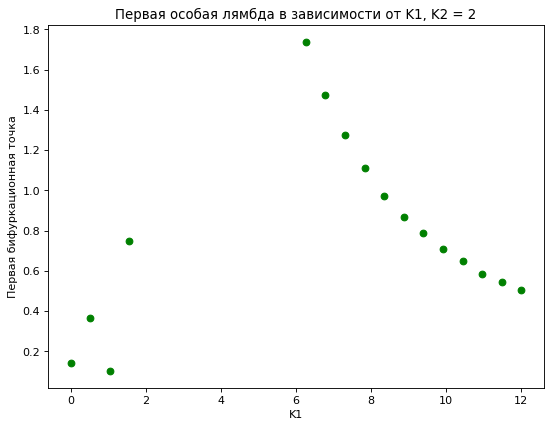

In [22]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(k1s_pos, firsts_k1, c="green", label="First special lambda")
plt.xlabel("K1")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от K1, K2 = 2")

## （6， 12，24）

In [4]:
firsts = []
k1s = []

In [15]:
k1s_pos = []
from tqdm import tqdm
filename = "bifucation_set"
import warnings
warnings.filterwarnings("ignore")
size = 25
linespk11 = np.linspace(6., 12., size)
linsp = [0., 2., 100]
firsts_k1 = []
for ind1, temp in tqdm(enumerate(linespk11)):
        D, A = 10, 2.0
        K1, K2 = temp, 1
        k11, k12, k13, k21, k22, k23 = 0, K1, K2, 0, K2, K1
        init_approx = [0] * 4
        lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
        print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = temp, K2 = 1, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
        K = [k11, k12, k13, k21, k22, k23]
        dets, lambdas_for_plot, la_zero, la_change = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 1000, filename)
        dets = dets[1:]
        lambdas_for_plot = lambdas_for_plot[1:]
        if len(la_zero) == 0:
            continue
        print("first root = ", la_zero[0])
        firsts_k1.append(la_zero[0])
        k1s_pos.append(K1)


0it [00:00, ?it/s]

D = 10, A = 2.0, K1 = 6.0, K2 = 1, linspace(0.0, 2.0, 100)


1it [00:24, 24.61s/it]

D = 10, A = 2.0, K1 = 6.25, K2 = 1, linspace(0.0, 2.0, 100)


2it [00:48, 24.47s/it]

D = 10, A = 2.0, K1 = 6.5, K2 = 1, linspace(0.0, 2.0, 100)


3it [01:12, 24.30s/it]

D = 10, A = 2.0, K1 = 6.75, K2 = 1, linspace(0.0, 2.0, 100)


4it [01:36, 24.19s/it]

D = 10, A = 2.0, K1 = 7.0, K2 = 1, linspace(0.0, 2.0, 100)


5it [02:00, 24.03s/it]

D = 10, A = 2.0, K1 = 7.25, K2 = 1, linspace(0.0, 2.0, 100)


6it [02:24, 23.95s/it]

D = 10, A = 2.0, K1 = 7.5, K2 = 1, linspace(0.0, 2.0, 100)


7it [02:47, 23.96s/it]

D = 10, A = 2.0, K1 = 7.75, K2 = 1, linspace(0.0, 2.0, 100)


8it [03:11, 23.73s/it]

D = 10, A = 2.0, K1 = 8.0, K2 = 1, linspace(0.0, 2.0, 100)


9it [03:35, 23.87s/it]

D = 10, A = 2.0, K1 = 8.25, K2 = 1, linspace(0.0, 2.0, 100)


10it [03:58, 23.59s/it]

D = 10, A = 2.0, K1 = 8.5, K2 = 1, linspace(0.0, 2.0, 100)


11it [04:38, 28.51s/it]

D = 10, A = 2.0, K1 = 8.75, K2 = 1, linspace(0.0, 2.0, 100)


12it [05:04, 27.72s/it]

D = 10, A = 2.0, K1 = 9.0, K2 = 1, linspace(0.0, 2.0, 100)


13it [05:30, 27.21s/it]

D = 10, A = 2.0, K1 = 9.25, K2 = 1, linspace(0.0, 2.0, 100)


14it [05:56, 26.89s/it]

D = 10, A = 2.0, K1 = 9.5, K2 = 1, linspace(0.0, 2.0, 100)


15it [06:23, 26.94s/it]

D = 10, A = 2.0, K1 = 9.75, K2 = 1, linspace(0.0, 2.0, 100)


16it [06:51, 27.21s/it]

D = 10, A = 2.0, K1 = 10.0, K2 = 1, linspace(0.0, 2.0, 100)


17it [07:18, 27.18s/it]

D = 10, A = 2.0, K1 = 10.25, K2 = 1, linspace(0.0, 2.0, 100)


18it [07:46, 27.55s/it]

D = 10, A = 2.0, K1 = 10.5, K2 = 1, linspace(0.0, 2.0, 100)


19it [08:14, 27.75s/it]

D = 10, A = 2.0, K1 = 10.75, K2 = 1, linspace(0.0, 2.0, 100)


20it [08:43, 28.07s/it]

D = 10, A = 2.0, K1 = 11.0, K2 = 1, linspace(0.0, 2.0, 100)


21it [09:12, 28.37s/it]

D = 10, A = 2.0, K1 = 11.25, K2 = 1, linspace(0.0, 2.0, 100)


22it [09:42, 28.68s/it]

D = 10, A = 2.0, K1 = 11.5, K2 = 1, linspace(0.0, 2.0, 100)


23it [10:11, 28.83s/it]

D = 10, A = 2.0, K1 = 11.75, K2 = 1, linspace(0.0, 2.0, 100)


24it [10:41, 29.10s/it]

D = 10, A = 2.0, K1 = 12.0, K2 = 1, linspace(0.0, 2.0, 100)


25it [11:11, 26.86s/it]


Text(0.5, 1.0, 'Первая особая лямбда в зависимости от K1, K2 = 2')

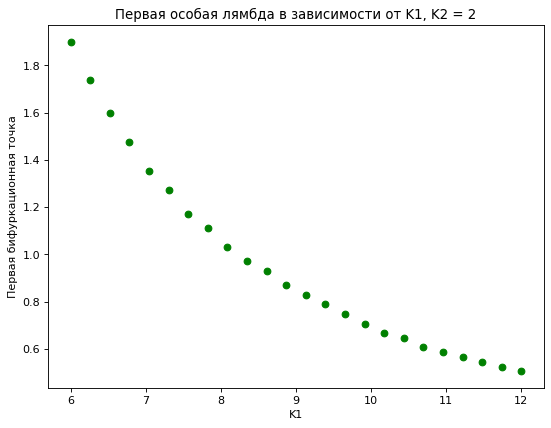

In [24]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(k1s_pos, firsts_k1, c="green", label="First special lambda", linewidth = 5)
plt.xlabel("K1")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от K1, K2 = 2")

## От k2

## k2, k1 = 1

In [77]:
k2s_pos = []
from tqdm import tqdm
filename = "bifucation_set"
import warnings
warnings.filterwarnings("ignore")
size = 25
linespk11 = np.linspace(7., 12., size)
linsp = [0., 2., 100]
firsts_k2 = []
for ind1, temp in tqdm(enumerate(linespk11)):
        D, A = 10, 2.0
        K1, K2 = 1, temp
        k11, k12, k13, k21, k22, k23 = 0, K1, K2, 0, K2, K1
        init_approx = [0] * 4
        lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
        print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = 1, K2 = temp, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
        K = [k11, k12, k13, k21, k22, k23]
        dets, lambdas_for_plot, la_zero, la_change = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 1000, filename)
        dets = dets[1:]
        lambdas_for_plot = lambdas_for_plot[1:]
        if len(la_zero) == 0:
            continue
#         fig = plt.figure(figsize=(15, 5))
#         ax = fig.gca()
#         ax.set_xlabel("Lambda")
#         ax.set_ylabel("Det")
#         plt.scatter(lambdas_for_plot, dets, s = 3, color = 'red')
#         plt.title('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij1, K2 = ij2, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
#         plt.grid()
#         plt.show()
        print("first root = ", la_zero[0])
        firsts_k2.append(la_zero[0])
        k2s_pos.append(K2)


0it [00:00, ?it/s]

D = 10, A = 2.0, K1 = 1, K2 = 7.0, linspace(0.0, 2.0, 100)


1it [00:20, 20.69s/it]

special lambda at 0.5656565656565657
first root =  0.5656565656565657
D = 10, A = 2.0, K1 = 1, K2 = 7.208333333333333, linspace(0.0, 2.0, 100)


2it [00:38, 19.95s/it]

special lambda at 0.5454545454545455
first root =  0.5454545454545455
D = 10, A = 2.0, K1 = 1, K2 = 7.416666666666667, linspace(0.0, 2.0, 100)


3it [01:28, 28.79s/it]

special lambda at 2.0
first root =  2.0
D = 10, A = 2.0, K1 = 1, K2 = 7.625, linspace(0.0, 2.0, 100)


4it [01:49, 26.53s/it]

special lambda at 0.5050505050505051
first root =  0.5050505050505051
D = 10, A = 2.0, K1 = 1, K2 = 7.833333333333333, linspace(0.0, 2.0, 100)


5it [02:09, 24.65s/it]

special lambda at 0.5050505050505051
first root =  0.5050505050505051
D = 10, A = 2.0, K1 = 1, K2 = 8.041666666666666, linspace(0.0, 2.0, 100)


6it [02:25, 22.08s/it]

special lambda at 0.48484848484848486
first root =  0.48484848484848486
D = 10, A = 2.0, K1 = 1, K2 = 8.25, linspace(0.0, 2.0, 100)


7it [03:00, 25.87s/it]

D = 10, A = 2.0, K1 = 1, K2 = 8.458333333333334, linspace(0.0, 2.0, 100)


8it [03:24, 25.14s/it]

special lambda at 0.4646464646464647
first root =  0.4646464646464647
D = 10, A = 2.0, K1 = 1, K2 = 8.666666666666666, linspace(0.0, 2.0, 100)


9it [04:03, 29.52s/it]

D = 10, A = 2.0, K1 = 1, K2 = 8.875, linspace(0.0, 2.0, 100)


10it [04:29, 28.26s/it]

special lambda at 0.42424242424242425
first root =  0.42424242424242425
D = 10, A = 2.0, K1 = 1, K2 = 9.083333333333334, linspace(0.0, 2.0, 100)


11it [04:50, 26.07s/it]

special lambda at 0.42424242424242425
first root =  0.42424242424242425
D = 10, A = 2.0, K1 = 1, K2 = 9.291666666666668, linspace(0.0, 2.0, 100)


12it [05:16, 26.08s/it]

special lambda at 0.4040404040404041
first root =  0.4040404040404041
D = 10, A = 2.0, K1 = 1, K2 = 9.5, linspace(0.0, 2.0, 100)


13it [05:30, 22.51s/it]

special lambda at 0.4040404040404041
first root =  0.4040404040404041
D = 10, A = 2.0, K1 = 1, K2 = 9.708333333333334, linspace(0.0, 2.0, 100)


14it [06:06, 26.48s/it]

special lambda at 1.474747474747475
first root =  1.474747474747475
D = 10, A = 2.0, K1 = 1, K2 = 9.916666666666668, linspace(0.0, 2.0, 100)


15it [06:27, 24.94s/it]

special lambda at 0.38383838383838387
first root =  0.38383838383838387
D = 10, A = 2.0, K1 = 1, K2 = 10.125, linspace(0.0, 2.0, 100)


16it [06:36, 20.03s/it]

special lambda at 0.36363636363636365
first root =  0.36363636363636365
D = 10, A = 2.0, K1 = 1, K2 = 10.333333333333334, linspace(0.0, 2.0, 100)


17it [06:52, 19.06s/it]

special lambda at 0.36363636363636365
first root =  0.36363636363636365
D = 10, A = 2.0, K1 = 1, K2 = 10.541666666666668, linspace(0.0, 2.0, 100)


18it [07:13, 19.55s/it]

special lambda at 0.36363636363636365
first root =  0.36363636363636365
D = 10, A = 2.0, K1 = 1, K2 = 10.75, linspace(0.0, 2.0, 100)


19it [07:57, 26.95s/it]

D = 10, A = 2.0, K1 = 1, K2 = 10.958333333333334, linspace(0.0, 2.0, 100)


20it [08:06, 21.36s/it]

special lambda at 0.3434343434343435
first root =  0.3434343434343435
D = 10, A = 2.0, K1 = 1, K2 = 11.166666666666668, linspace(0.0, 2.0, 100)


21it [08:37, 24.32s/it]

special lambda at 1.2525252525252526
first root =  1.2525252525252526
D = 10, A = 2.0, K1 = 1, K2 = 11.375, linspace(0.0, 2.0, 100)


22it [08:52, 21.71s/it]

special lambda at 0.32323232323232326
first root =  0.32323232323232326
D = 10, A = 2.0, K1 = 1, K2 = 11.583333333333334, linspace(0.0, 2.0, 100)


23it [09:05, 18.94s/it]

special lambda at 0.32323232323232326
first root =  0.32323232323232326
D = 10, A = 2.0, K1 = 1, K2 = 11.791666666666668, linspace(0.0, 2.0, 100)


24it [09:17, 16.75s/it]

special lambda at 0.32323232323232326
first root =  0.32323232323232326
D = 10, A = 2.0, K1 = 1, K2 = 12.0, linspace(0.0, 2.0, 100)


25it [09:25, 22.64s/it]

special lambda at 0.30303030303030304
first root =  0.30303030303030304


Text(0.5, 1.0, 'Первая особая лямбда в зависимости от K2, K1 = 1 ')

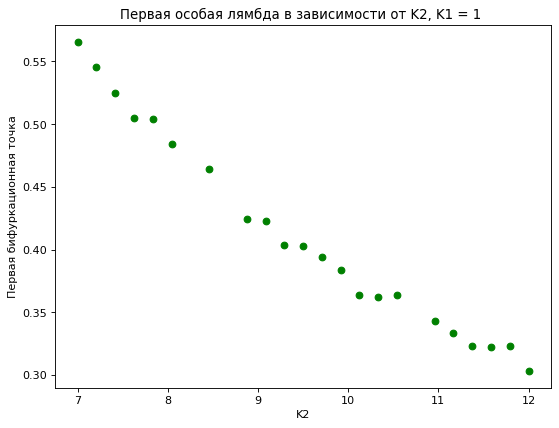

In [90]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(k2s_pos, firsts_k2, c="green", label="First special lambda")
plt.xlabel("K2")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от K2, K1 = 1 ")


0it [00:00, ?it/s]

D = 10, A = 2.0, K1 = 2, K2 = 6.0, linspace(0.0, 2.0, 100)


1it [00:24, 24.49s/it]

special lambda at 0.9292929292929294
first root =  0.9292929292929294
D = 10, A = 2.0, K1 = 2, K2 = 6.260869565217392, linspace(0.0, 2.0, 100)


2it [00:49, 24.74s/it]

special lambda at 0.8484848484848485
first root =  0.8484848484848485
D = 10, A = 2.0, K1 = 2, K2 = 6.521739130434782, linspace(0.0, 2.0, 100)


3it [01:13, 24.54s/it]

special lambda at 0.8080808080808082
first root =  0.8080808080808082
D = 10, A = 2.0, K1 = 2, K2 = 6.782608695652174, linspace(0.0, 2.0, 100)


4it [01:28, 21.54s/it]

special lambda at 0.7474747474747475
first root =  0.7474747474747475
D = 10, A = 2.0, K1 = 2, K2 = 7.043478260869565, linspace(0.0, 2.0, 100)


5it [01:43, 19.66s/it]

special lambda at 0.7070707070707072
first root =  0.7070707070707072
D = 10, A = 2.0, K1 = 2, K2 = 7.304347826086957, linspace(0.0, 2.0, 100)


6it [01:58, 18.14s/it]

special lambda at 0.6666666666666667
first root =  0.6666666666666667
D = 10, A = 2.0, K1 = 2, K2 = 7.565217391304348, linspace(0.0, 2.0, 100)


7it [02:31, 22.81s/it]

special lambda at 0.6464646464646465
first root =  0.6464646464646465
D = 10, A = 2.0, K1 = 2, K2 = 7.826086956521739, linspace(0.0, 2.0, 100)


8it [02:59, 24.23s/it]

special lambda at 0.6060606060606061
first root =  0.6060606060606061
D = 10, A = 2.0, K1 = 2, K2 = 8.08695652173913, linspace(0.0, 2.0, 100)


9it [03:24, 24.51s/it]

special lambda at 0.5858585858585859
first root =  0.5858585858585859
D = 10, A = 2.0, K1 = 2, K2 = 8.347826086956522, linspace(0.0, 2.0, 100)


10it [03:53, 25.88s/it]

special lambda at 0.5656565656565657
first root =  0.5656565656565657
D = 10, A = 2.0, K1 = 2, K2 = 8.608695652173914, linspace(0.0, 2.0, 100)


11it [04:20, 26.05s/it]

special lambda at 0.5454545454545455
first root =  0.5454545454545455
D = 10, A = 2.0, K1 = 2, K2 = 8.869565217391305, linspace(0.0, 2.0, 100)


12it [04:36, 23.08s/it]

special lambda at 0.5050505050505051
first root =  0.5050505050505051
D = 10, A = 2.0, K1 = 2, K2 = 9.130434782608695, linspace(0.0, 2.0, 100)


13it [05:18, 28.65s/it]

D = 10, A = 2.0, K1 = 2, K2 = 9.391304347826086, linspace(0.0, 2.0, 100)


14it [05:41, 27.18s/it]

special lambda at 0.48484848484848486
first root =  0.48484848484848486
D = 10, A = 2.0, K1 = 2, K2 = 9.652173913043478, linspace(0.0, 2.0, 100)


15it [05:49, 21.20s/it]

special lambda at 0.4646464646464647
first root =  0.4646464646464647
D = 10, A = 2.0, K1 = 2, K2 = 9.91304347826087, linspace(0.0, 2.0, 100)


16it [06:02, 18.88s/it]

special lambda at 0.4444444444444445
first root =  0.4444444444444445
D = 10, A = 2.0, K1 = 2, K2 = 10.173913043478262, linspace(0.0, 2.0, 100)


17it [06:20, 18.49s/it]

special lambda at 0.42424242424242425
first root =  0.42424242424242425
D = 10, A = 2.0, K1 = 2, K2 = 10.434782608695652, linspace(0.0, 2.0, 100)


18it [06:36, 17.83s/it]

special lambda at 0.42424242424242425
first root =  0.42424242424242425
D = 10, A = 2.0, K1 = 2, K2 = 10.695652173913043, linspace(0.0, 2.0, 100)


19it [06:51, 16.97s/it]

special lambda at 0.4040404040404041
first root =  0.4040404040404041
D = 10, A = 2.0, K1 = 2, K2 = 10.956521739130434, linspace(0.0, 2.0, 100)


20it [07:19, 20.40s/it]

special lambda at 1.4343434343434345
first root =  1.4343434343434345
D = 10, A = 2.0, K1 = 2, K2 = 11.217391304347826, linspace(0.0, 2.0, 100)


21it [07:56, 25.34s/it]

D = 10, A = 2.0, K1 = 2, K2 = 11.478260869565217, linspace(0.0, 2.0, 100)


22it [08:26, 26.81s/it]

special lambda at 0.36363636363636365
first root =  0.36363636363636365
D = 10, A = 2.0, K1 = 2, K2 = 11.73913043478261, linspace(0.0, 2.0, 100)


23it [08:45, 24.31s/it]

special lambda at 0.36363636363636365
first root =  0.36363636363636365
D = 10, A = 2.0, K1 = 2, K2 = 12.0, linspace(0.0, 2.0, 100)


24it [08:59, 22.48s/it]

special lambda at 0.3434343434343435
first root =  0.3434343434343435


Text(0.5, 1.0, 'Первая особая лямбда в зависимости от K2, K1 = 2 ')

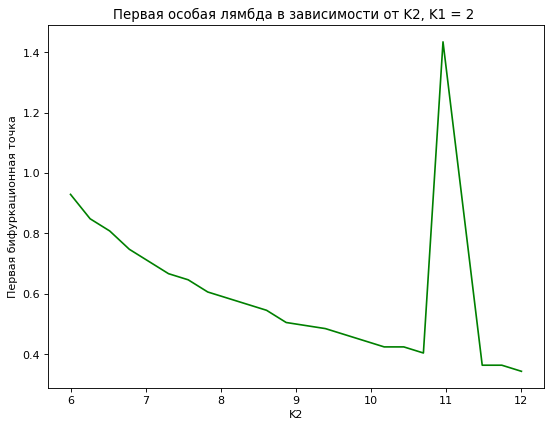

In [53]:
k2s_pos = []
from tqdm import tqdm
filename = "bifucation_set"
import warnings
warnings.filterwarnings("ignore")
size = 24
linespk11 = np.linspace(6., 12., size)
linsp = [0., 2., 100]
firsts_k2 = []
for ind1, temp in tqdm(enumerate(linespk11)):
        D, A = 10, 2.0
        K1, K2 = 2, temp
        k11, k12, k13, k21, k22, k23 = 0, K1, K2, 0, K2, K1
        init_approx = [0] * 4
        lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
        print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = 2, K2 = temp, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
        K = [k11, k12, k13, k21, k22, k23]
        dets, lambdas_for_plot, la_zero, la_change = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 1000, filename)
        dets = dets[1:]
        lambdas_for_plot = lambdas_for_plot[1:]
        if len(la_zero) == 0:
            continue
#         fig = plt.figure(figsize=(15, 5))
#         ax = fig.gca()
#         ax.set_xlabel("Lambda")
#         ax.set_ylabel("Det")
#         plt.scatter(lambdas_for_plot, dets, s = 3, color = 'red')
#         plt.title('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij1, K2 = ij2, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
#         plt.grid()
#         plt.show()
        print("first root = ", la_zero[0])
        firsts_k2.append(la_zero[0])
        k2s_pos.append(K2)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(k2s_pos, firsts_k2, c="green", label="First special lambda")
plt.xlabel("K2")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от K2, K1 = 2 ")

Text(0.5, 1.0, 'Первая особая лямбда в зависимости от K2, K1 = 2 ')

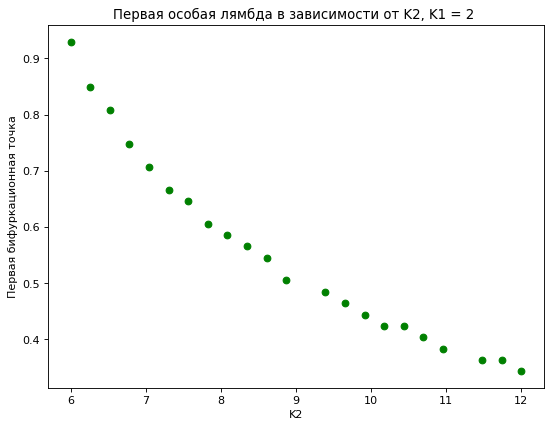

In [61]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(k2s_pos, firsts_k2, c="green", label="First special lambda")
plt.xlabel("K2")
plt.ylabel("Первая бифуркационная точка")
plt.title("Первая особая лямбда в зависимости от K2, K1 = 2 ")

## k1, k2 не фик

In [ ]:
k2s_pos = []
from tqdm import tqdm
filename = "bifucation_set"
import warnings
warnings.filterwarnings("ignore")
size = 4
linespk11 = np.linspace(1.5, 1.7, size)
linespk22 = np.linspace(10., 10.2, size)
linsp = [0., 1.0, 100]
firsts = [[0.]* size for i in range(size)]
k1k2 = []
matrix_dets = []
matrix_lams = []
for ind1, K1_ in tqdm(enumerate(linespk11)):
    for ind2, K2_ in tqdm(enumerate(linespk22)):
        D, A = 10, 2.0
        k11, k12, k13, k21, k22, k23 = 0, K1_, K2_, 0, K2_, K1_
        init_approx = [0] * 4
        lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
        print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = K1_, K2 = K2_, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
        K = [k11, k12, k13, k21, k22, k23]
        dets, lambdas_for_plot, la_zero, la_change = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 1000, filename)
        dets = dets[1:]
        lambdas_for_plot = lambdas_for_plot[1:]
        matrix_dets.append(dets)
        matrix_lams.append(lambdas_for_plot)
        if len(la_zero) == 0:
            continue
        print("first root = ", la_zero[0])
        k1k2.append([la_zero[0], K1_, K2_])
        firsts[ind1][ind2] = la_zero[0]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

D = 10, A = 2.0, K1 = 1.5, K2 = 10.0, linspace(0.0, 1.0, 100)



1it [00:07,  7.48s/it]

special lambda at 0.07070707070707072
first root =  0.07070707070707072
D = 10, A = 2.0, K1 = 1.5, K2 = 10.066666666666666, linspace(0.0, 1.0, 100)


In [22]:
for line in firsts:
    print(line)

[0.07070707070707072, 0.19191919191919193, 0.22222222222222224, 0.30303030303030304]
[0.06060606060606061, 0.22222222222222224, 0.30303030303030304, 0.08080808080808081]
[0.22222222222222224, 0.31313131313131315, 0.20202020202020204, 0.22222222222222224]
[0.32323232323232326, 0.20202020202020204, 0.20202020202020204, 0.23232323232323235]


In [26]:
k1s_ = []
k2s_ = []
lams = []
for elem in k1k2:
    lams.append(elem[0])
    k1s_.append(elem[1])
    k2s_.append(elem[2])
print(k1s_)
print(k2s_)
print(lams)

[1.5, 1.5, 1.5, 1.5, 1.5666666666666667, 1.5666666666666667, 1.5666666666666667, 1.5666666666666667, 1.6333333333333333, 1.6333333333333333, 1.6333333333333333, 1.6333333333333333, 1.7, 1.7, 1.7, 1.7]
[10.0, 10.066666666666666, 10.133333333333333, 10.2, 10.0, 10.066666666666666, 10.133333333333333, 10.2, 10.0, 10.066666666666666, 10.133333333333333, 10.2, 10.0, 10.066666666666666, 10.133333333333333, 10.2]
[0.07070707070707072, 0.19191919191919193, 0.22222222222222224, 0.30303030303030304, 0.06060606060606061, 0.22222222222222224, 0.30303030303030304, 0.08080808080808081, 0.22222222222222224, 0.31313131313131315, 0.20202020202020204, 0.22222222222222224, 0.32323232323232326, 0.20202020202020204, 0.20202020202020204, 0.23232323232323235]


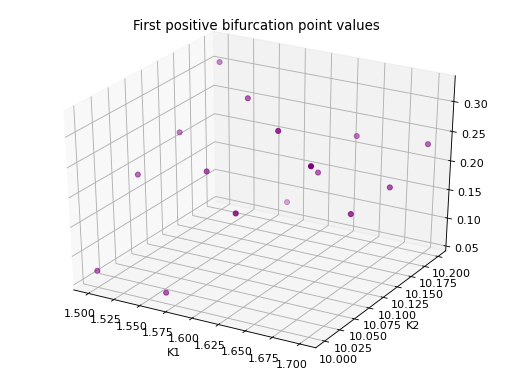

In [27]:
from pylab import figure, cm
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.array(res)[1:, 3:]
xline, yline = np.meshgrid(np.linspace(1.5, 1.7, size), np.linspace(10., 10.2, size))
# ax.scatter3D(xline, yline, zline, 50, cmap=cm.jet)
# print(linespk1, linespk2, zline, sep='\n')

ax.scatter3D(k1s_, k2s_, lams, color='purple')
# ax.plot_surface(xline, yline, np.array(firsts), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel("K1")
ax.set_ylabel("K2")
# ax.set_zlabel("bif lambdas")
plt.title("First positive bifurcation point values")
plt.show()

## SVD

In [9]:
A = 2
time_steps = np.linspace(-A, A, 100)
def lambda_iterate_svd(linsp, D, K, A, init_approx, system, bc, draw_nth, filename):
    global la
    params, bc_params = [], []
    lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
    s1 = []
    s2 = []
    steps = []
    abcFile = open(filename, 'a')
    y_approx = init_approx
    cnt = 0
#     time_steps = np.linspace(-A, A, 100)
    for la in lambdas:
        cnt += 1
        result = shooting(time_steps, y_approx, system, params, bc, bc_params, filename)
        if result[0] > 1:
            print("MISTAKE AT la = ", la, "det = ", det, file=abcFile)
            continue
        print("y_approx = ", y_approx, " la = ", la, file = abcFile)
            
    # сохранить точку смены знака
        y_approx = result[1]
        steps.append(la)
        s1.append(result[4][-1])
        s2.append(result[4][-2])
    return s1, s2, steps

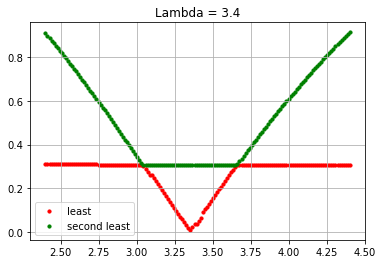

In [10]:
la = 3.4
old_la = la
delta = 1
linsp = [la - delta, la + delta, 150]
y0 = [-2.81031432e+00,  5.99377879e-02, -1.02826227e-07, -7.53026378e-07]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=10, label = "least")
plt.scatter(steps_, s2_, color="green", s=10, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

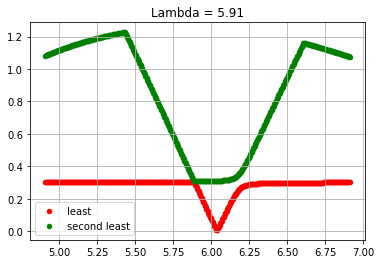

In [121]:
la =  5.91
old_la = la
delta = 1
linsp = [la - delta, la + delta, 500]
y0 = [-4.91965201e+00,  5.96693622e-02,  1.92480467e-09,  2.89947084e-08]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

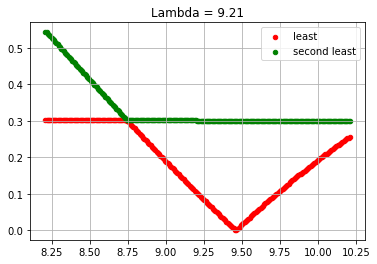

In [122]:
la =  9.21
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-7.70420780e+00,  5.95402880e-02, -3.39032545e-09, -2.28032640e-08]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

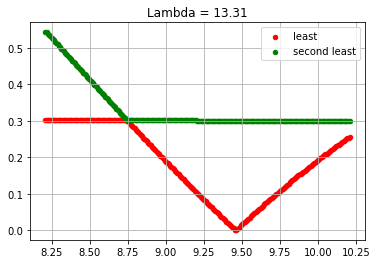

In [123]:
la =  13.313313313313314
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-1.11638958e+01,  5.94700922e-02, -3.93275515e-08, -2.49693845e-07]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

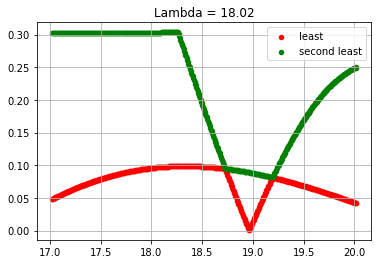

In [136]:
la =  18.01801801801802
old_la = la
delta = 1
linsp = [la - delta, la + delta + 1, 500]
y0 = [-1.51299212e+01,  5.94282369e-02, -1.98922171e-09, -1.30316749e-08]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

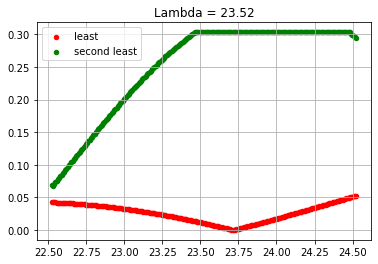

In [125]:
la =  23.523523523523526
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-1.97710349e+01,  5.94010128e-02, -8.25309381e-09, -5.25299159e-08]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

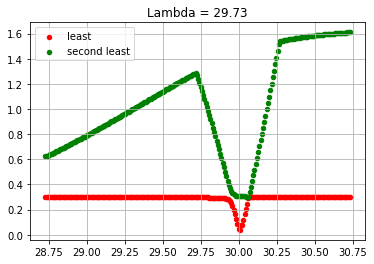

In [133]:
la =  29.72972972972973
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-2.50028482e+01,  5.93823310e-02, -6.41453135e-10, -4.16828726e-09]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

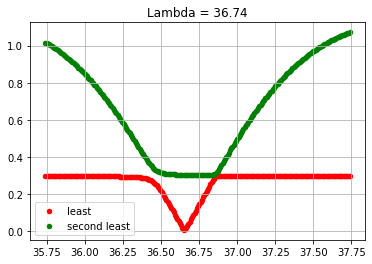

In [12]:
la =  36.74
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-3.09097415e+01,  5.93692547e-02, -7.17763815e-08, -4.62051036e-07]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

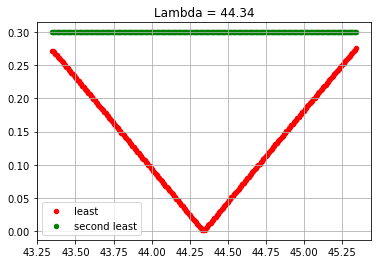

In [11]:
la =  44.34434434434435
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-3.73229450e+01,  5.93591089e-02, -1.72490030e-10, -1.11617342e-09]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Lambda = {}".format(round(old_la, 2)))
plt.legend()
plt.grid()
plt.show()

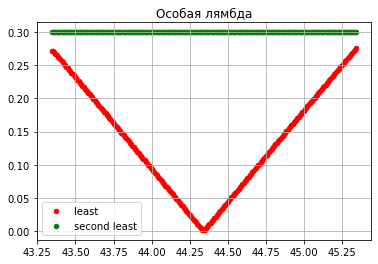

In [18]:
la =  44.34434434434435
old_la = la
delta = 1
linsp = [la - delta, la + delta, 250]
y0 = [-3.73229450e+01,  5.93591089e-02, -1.72490030e-10, -1.11617342e-09]
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Особая лямбда")
plt.legend()
plt.grid()
plt.show()

<ipython-input-5-7d1752ddde68>:7: RuntimeWarning: overflow encountered in double_scalars
  return (y + k11 * y**2 + 2 * k12 * z * y + k13 * z**2 + la) / D    # d^2y / dx^2
<ipython-input-5-7d1752ddde68>:7: RuntimeWarning: invalid value encountered in double_scalars
  return (y + k11 * y**2 + 2 * k12 * z * y + k13 * z**2 + la) / D    # d^2y / dx^2
<ipython-input-5-7d1752ddde68>:14: RuntimeWarning: overflow encountered in double_scalars
  return (z + k21 * y**2 + 2 * k22 * z * y + k23 * z**2 + la) / D     # d^2z / dx^2
<ipython-input-5-7d1752ddde68>:14: RuntimeWarning: invalid value encountered in double_scalars
  return (z + k21 * y**2 + 2 * k22 * z * y + k23 * z**2 + la) / D     # d^2z / dx^2


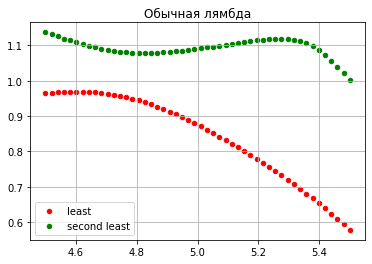

In [17]:
la =  5
old_la = la
delta = 0.5
linsp = [la - delta, la + delta, 50]
y0 = [0] * 4
D, A, K1, K2 = 10, 2.0, 1.57, 10
k11, k12, k13, k21, k22, k23 = 0, 1.57, 10, 0, 10, 1.57 
K = [k11, k12, k13, k21, k22, k23]
filename="svds"
s1_, s2_, steps_ = lambda_iterate_svd(linsp, D, A, K, y0, system, bc, 50, filename)
plt.scatter(steps_, s1_, color="red", s=20, label = "least")
plt.scatter(steps_, s2_, color="green", s=20, label = "second least")
plt.title("Обычная лямбда")
plt.legend()
plt.grid()
plt.show()

# y(-A) = y(A) = z(-A) = z(A) = 0

In [10]:
def boarder_values(l):
    return np.array([l[0], l[1], l[4], l[5]])
#  0      1      2      3     4    5    6     7   
# y(-A) z(-A) y'(-A) z'(-A) y(A) z(A) y'(A) z'(A)

bc = boarder_values

In [10]:
glob_vals = []

def lambda_iterate(linsp, D, K, A, init_approx, system, bc, draw_nth, filename):
    global k11, k12, k13, k21, k22, k23
    global la
    params, bc_params = [], []
    lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
    lambdas_for_plot, dets = [], []
    y_approx = init_approx
    cnt = 0
    for la in lambdas:
        cnt += 1
        result = shooting(np.linspace(-A, A, 100), y_approx, system, params, bc, bc_params, filename)
        if result[0] > 1:
            continue
        if len(dets) > 0 and result[3] * dets[-1] < 0:
            print('Det Change, lambda = {lamb}'.format(lamb = round(la, 2)))
            print("y_approx = ", y_approx, " la = ", la)  # ------------------------------  print y_approx
        y_approx = result[1]
        lambdas_for_plot.append(la)
        dets.append(result[3])
    return dets, lambdas_for_plot

## DET LAMBDA GRAPH

In [7]:
filename = "dets"

D = 10, A = 2.0, K1 = 1.57, K2 = 10, linspace(0, 100, 1000)


<ipython-input-4-c27e69665a78>:121: RuntimeWarning: overflow encountered in double_scalars
  return (y + k11 * y**2 + 2 * k12 * z * y + k13 * z**2 + la) / D    # d^2y / dx^2
<ipython-input-4-c27e69665a78>:121: RuntimeWarning: invalid value encountered in double_scalars
  return (y + k11 * y**2 + 2 * k12 * z * y + k13 * z**2 + la) / D    # d^2y / dx^2
<ipython-input-4-c27e69665a78>:128: RuntimeWarning: overflow encountered in double_scalars
  return (z + k21 * y**2 + 2 * k22 * z * y + k23 * z**2 + la) / D     # d^2z / dx^2
<ipython-input-4-c27e69665a78>:128: RuntimeWarning: invalid value encountered in double_scalars
  return (z + k21 * y**2 + 2 * k22 * z * y + k23 * z**2 + la) / D     # d^2z / dx^2
<ipython-input-4-c27e69665a78>:66: RuntimeWarning: invalid value encountered in less
  if (np.abs(redisuals) < 1e-6).all():
C:\Users\victo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)

Det Change, lambda = 1.2
y_approx =  [-0.14975259 -0.17271273  0.00167759  0.0020042 ]  la =  1.2012012012012012
Det Change, lambda = 10.31
y_approx =  [-1.78983788  0.71764783  0.01927263 -0.02823197]  la =  10.31031031031031
Det Change, lambda = 20.62
y_approx =  [-2.99522846  1.07710429  0.0305036  -0.0910035 ]  la =  20.62062062062062
Det Change, lambda = 47.55
y_approx =  [-7.58118513 -0.35818589  0.10043277  0.20562941]  la =  47.54754754754755


C:\Users\victo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Det Change, lambda = 81.28
y_approx =  [-9.90360188 -0.77382924  0.16049327  0.43069394]  la =  81.28128128128128


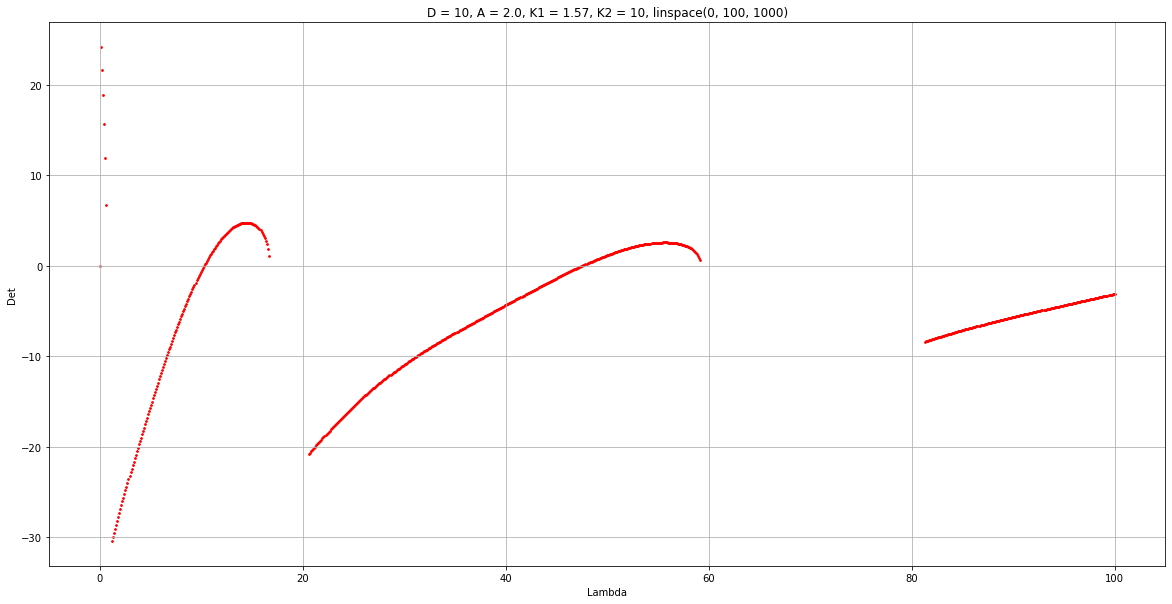

In [11]:
for ij in [1.57]:
    D, A, K1, K2 = 10, 2.0, ij, 10
    k11, k12, k13, k21, k22, k23 = 0, ij, 10, 0, 10, ij   #  0, K1, K2, 0, K2, K1
    init_approx =  [0, 0, 0, 0]
    linsp = [0, 100, 1000]
    lambdas = np.linspace(linsp[0], linsp[1], linsp[2])
    print('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij, K2 = 10, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
    K = [k11, k12, k13, k21, k22, k23]
    dets, lambdas_for_plot = lambda_iterate(linsp, D, K, A, init_approx, system, bc, 500, filename)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()    
    ax.set_xlabel("Lambda")
    ax.set_ylabel("Det")
    plt.scatter(lambdas_for_plot, dets, s = 3, color = 'red')
    plt.title('D = {D}, A = {A}, K1 = {K1}, K2 = {K2}, linspace({l1}, {l2}, {l3})'.format(D = D, A = A, K1 = ij, K2 = 10, l1 = linsp[0], l2 = linsp[1], l3 = linsp[2]))
    plt.grid()
    plt.show()